In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from medmnist import DermaMNIST
from captum.attr import GuidedGradCam, visualization as viz
import matplotlib.pyplot as plt
import numpy as np
import random
import optuna

c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ustawienie losowego ziarna dla powtarzalności wyników
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Set your desired seed value here


# Hiperparametry do tuningu
batch_size = 64
learning_rate = 0.001835420071451186
dropout_rate = 0.2615251891081807
epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Wczytanie i przetwarzanie DermaMNIST
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data preparation
train_dataset = DermaMNIST(root='./data', split="train", download=True, transform=transform_train, size=64)
test_dataset = DermaMNIST(root='./data', split="test", download=True, transform=transform_test, size=64)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet50(weights="IMAGENET1K_V1")
# Freeze all the weights
for param in model.parameters():
    param.requires_grad = False

# Dostosowanie ostatnich warstw
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(128, 7)  # 7 klas w DermaMNIST
)

# Ensure the classifier's weights are trainable
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# Funkcja kosztu i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# 3. Trenowanie modelu
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        target = target.long()  # Zamień na torch.long
        if target.dim() > 1:    # Usuń nadmiarowe wymiary
            target = target.squeeze()

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# 4. Testowanie modelu
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.long()  # Zamień na torch.long
            if target.dim() > 1:    # Usuń nadmiarowe wymiary
                target = target.squeeze()
            outputs = model(data)
            test_loss += criterion(outputs, target).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

# Training and testing loop
train_losses = []
test_losses = []
accuracies = []
patience = 3  # Early stopping patience
best_test_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    # Check for improvement
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    # # Early stopping condition
    # if patience_counter >= patience:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break



Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/50], Train Loss: 0.9973, Test Loss: 0.9809, Accuracy: 69.08%
Epoch [2/50], Train Loss: 0.8886, Test Loss: 0.8928, Accuracy: 68.68%
Epoch [3/50], Train Loss: 0.8574, Test Loss: 0.8437, Accuracy: 71.37%
Epoch [4/50], Train Loss: 0.8592, Test Loss: 0.9032, Accuracy: 69.63%
Epoch [5/50], Train Loss: 0.8332, Test Loss: 0.8900, Accuracy: 70.52%
Epoch [6/50], Train Loss: 0.8482, Test Loss: 0.8326, Accuracy: 71.17%
Epoch [7/50], Train Loss: 0.8381, Test Loss: 0.8453, Accuracy: 70.17%
Epoch [8/50], Train Loss: 0.8301, Test Loss: 0.8627, Accuracy: 71.02%
Epoch [9/50], Train Loss: 0.8215, Test Loss: 0.8030, Accuracy: 71.32%
Epoch [10/50], Train Loss: 0.8218, Test Loss: 0.8377, Accuracy: 71.02%
Epoch [11/50], Train Loss: 0.8134, Test Loss: 0.8519, Accuracy: 70.57%
Epoch [12/50], Train Loss: 0.8021, Test Loss: 0.8035, Accuracy: 72.07%
Epoch [13/50], Train Loss: 0.8031, 

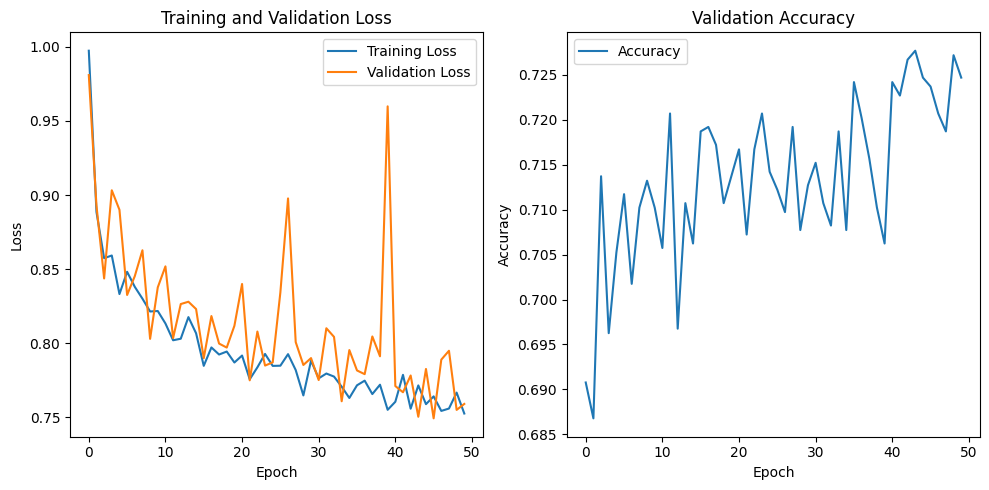

In [3]:
# Plotting the training progress
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


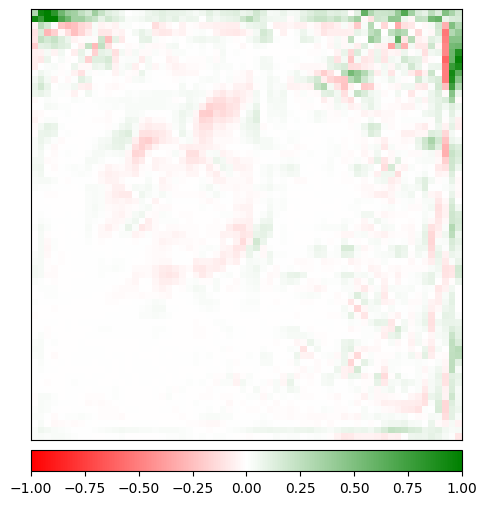

In [6]:
# 5. XAI: Grad-CAM dla DermaMNIST
layer = model.layer4[-1]
guided_gc = GuidedGradCam(model, layer)

# Wybierz próbkę testową
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device).squeeze().long()

# Grad-CAM dla pierwszej próbki
input_image = data[8].unsqueeze(0)  # Dodaj wymiar batcha
attributions = guided_gc.attribute(input_image, target=torch.argmax(model(input_image)).item())

# Wizualizacja Grad-CAM
grand_cam = viz.visualize_image_attr(
    np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(data[0].cpu().numpy(), (1, 2, 0)),
    method="heat_map",
    sign="all",
    show_colorbar=True
)